#  Разведочный анализ данных 

#### В датасетах представлена информация о выданных займах по всему миру от компании KIVA

Как это работает:
1.	Заёмщик обращается за кредитом (два типа моделей: прямой заём и заём через партнёра)
2.	Заявка публикуется на KIVA (заявка проходит процедуру одобрения)
3.	Осуществляется сбор средств (сообщество KIVA принимает участие в сборе средств)
4.	Заёмщик погашает кредит ( кредиторы получают регулярные выплаты)


#### Выгрузка данных - kiva_loans  
Набор данных, который содержит большую часть информации о займах:  
  
**id** — уникальный идентификатор для кредита.  
**funded_amount** — сумма, выплаченная Kiva агенту на местах (USD).    
**loan_amount** — сумма, выплаченная полевым агентом заёмщику (USD).  
**sector** — сектор использования займа.  
**activity** — более детализированная категория.  
**use** — назначение суммы кредита.  
**country_code — ISO** -код страны страны, в которой был выдан заём.  
**country** — полное название страны, в которой был выдан кредит.  
**posted_time** — время, в которое заявка была опубликована на Kiva.  
**disbursed_time** — время, когда кредитный агент выдал заёмщику сумму.  
**funded_time** — время, когда заявка полностью финансируется кредиторами.  
**term_in_months** — срок, на который был выдан кредит, в месяцах.  
**lender_count** — общее количество кредиторов, которые внесли свой вклад в этот кредит.  
**loaner_genders** — разделённые запятыми буквы M, F, где каждый экземпляр представляет одного мужчину/женщину в группе.



#### Выяснить:  
*	В каких странах преобладают мужчины? Группа людей?   
*	Изучите несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей?   
*	Попробуйте найти связь между странами (регионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных?   
*	Зависимость пола заёмщика от региона планеты, сектора экономики.  
*	Влияние такого атрибута займа, как «Количество кредиторов» (lender_count) на суммы и сроки займов.  
*	Влияние показателя MPI (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.  
*	Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе Макрорегионов.


In [1]:
import numpy as np
import pandas as pd
import math
import missingno as msno
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set2')

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_kiva_loans = pd.read_csv("./data/kiva_loans.csv")
df_mpi = pd.read_csv("./data/datasets_12414_19728_kiva_mpi_region_locations.csv")

In [3]:

df_mpi_grouped = df_mpi\
    .groupby(['ISO', 'country', 'world_region'])['MPI']\
    .mean()\
    .fillna(0)\
    .reset_index()

df_kiva_loans = df_kiva_loans.merge(df_mpi_grouped, how='left', on='country')

 Посмотрим на наличие пропущенных значений, чтобы не столкнуться с неприятными сюрпризами при дальнейшей работе, с помощью модуля missingno

In [4]:
df_kiva_loans.head(5)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,ISO,world_region,MPI
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,...,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01,PAK,South Asia,0.233167
1,653053,575.0,575.0,Rickshaw,Transportation,to repair and maintain the auto rickshaw used ...,PK,Pakistan,Lahore,PKR,...,2014-01-02 09:17:23+00:00,11.0,14,NaN,"female, female",irregular,2014-01-01,PAK,South Asia,0.233167
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,2014-01-01 16:01:36+00:00,43.0,6,"user_favorite, user_favorite",female,bullet,2014-01-01,IND,South Asia,0.000000
3,653063,200.0,200.0,Embroidery,Arts,to purchase an embroidery machine and a variet...,PK,Pakistan,Lahore,PKR,...,2014-01-01 13:00:00+00:00,11.0,8,NaN,female,irregular,2014-01-01,PAK,South Asia,0.233167
4,653084,400.0,400.0,Milk Sales,Food,to purchase one buffalo.,PK,Pakistan,Abdul Hakeem,PKR,...,2014-01-01 19:18:51+00:00,14.0,16,NaN,female,monthly,2014-01-01,PAK,South Asia,0.233167


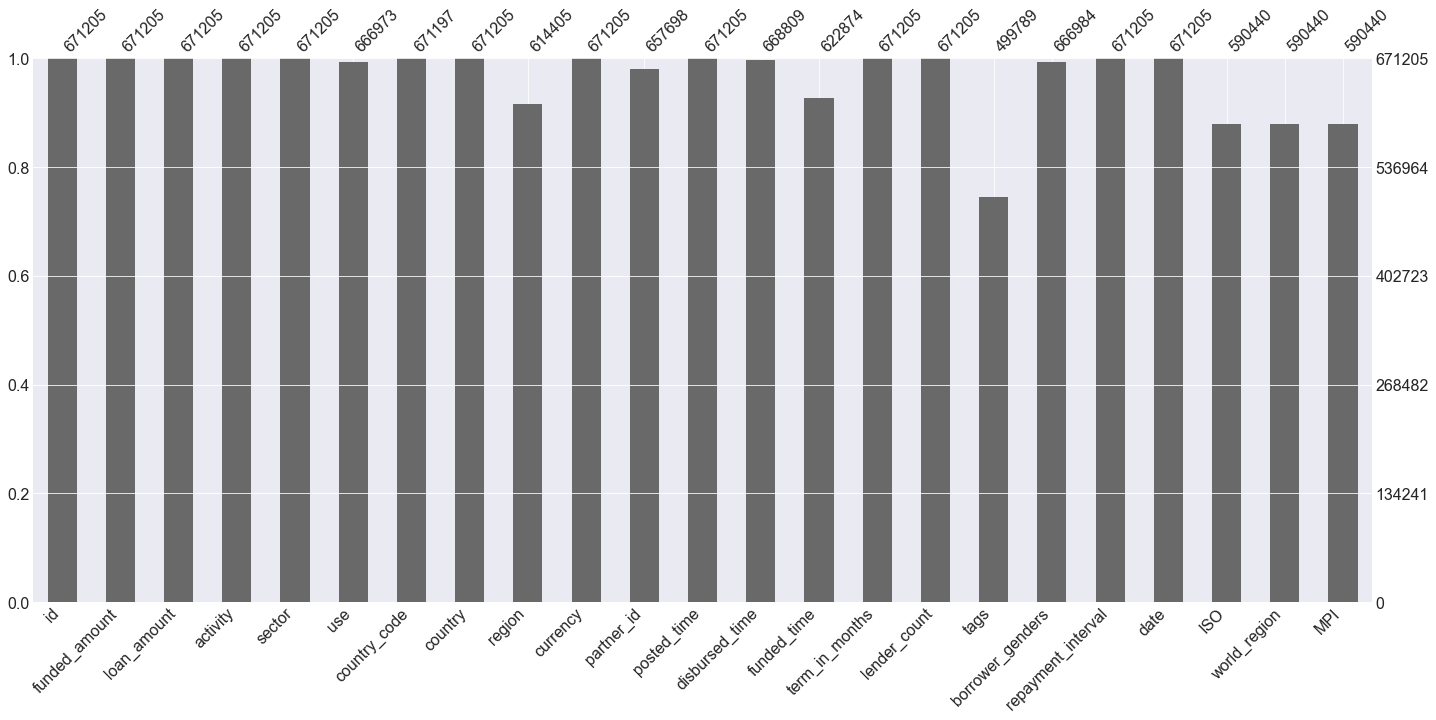

In [5]:
msno.bar(df_kiva_loans)

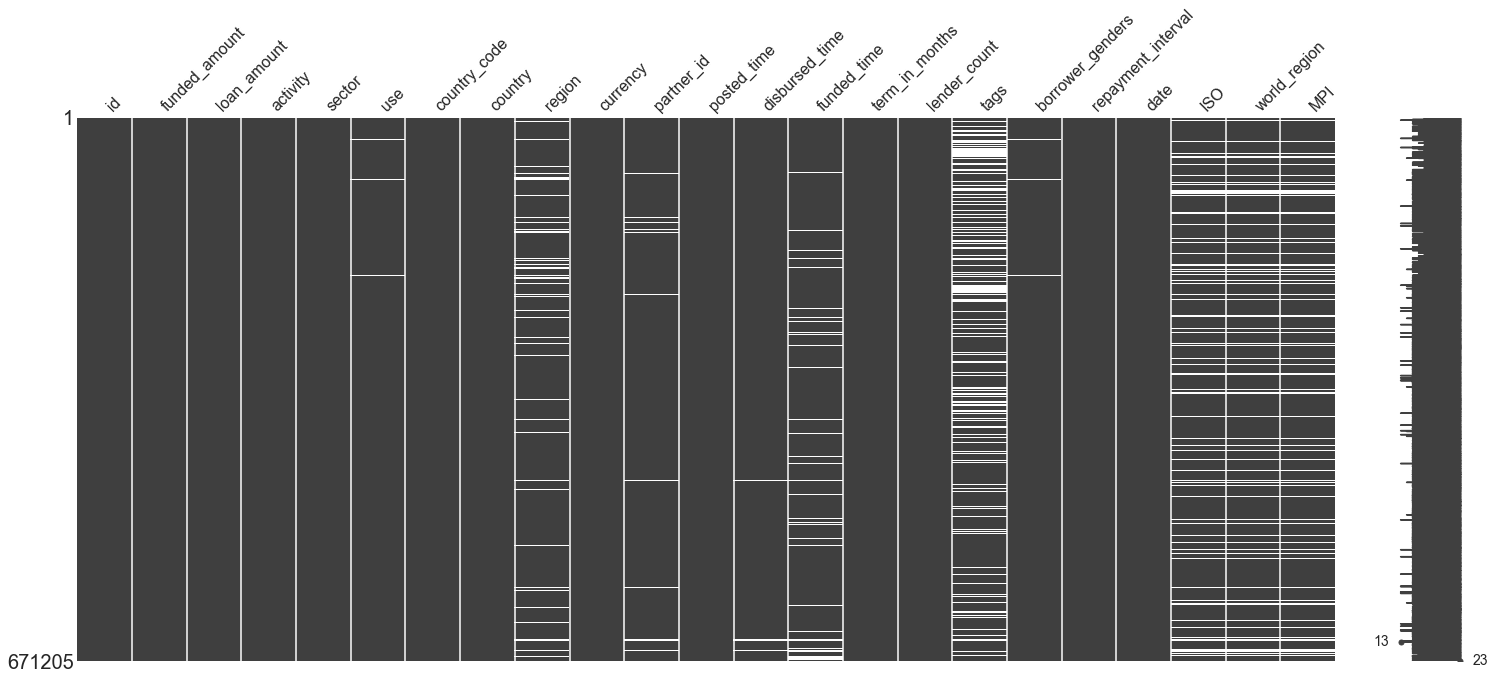

In [6]:
msno.matrix(df_kiva_loans)

Столбец тегов содержит много пропущенных значений. Также столбец с датой, когда запрашиваемая сумма была собрана на платформе Kiva, имеет около 8% пропусков. Это может означать либо то, что сумма пока не собрана, либо то, что она не была отражена в выгрузке корректно.

Далее приступим к изучению каждого атрибута датасета по отдельности и выведем ряд статистик для каждого из них.

In [7]:
df_kiva_loans.dtypes

id                      int64
funded_amount         float64
loan_amount           float64
activity               object
sector                 object
use                    object
country_code           object
country                object
region                 object
currency               object
partner_id            float64
posted_time            object
disbursed_time         object
funded_time            object
term_in_months        float64
lender_count            int64
tags                   object
borrower_genders       object
repayment_interval     object
date                   object
ISO                    object
world_region           object
MPI                   float64
dtype: object

In [8]:
df_kiva_loans.describe(include=[np.number])

,id,funded_amount,loan_amount,partner_id,term_in_months,lender_count,MPI
count,6.712050e+05,671205.000000,671205.000000,657698.000000,671205.000000,671205.000000,590440.000000
mean,9.932486e+05,785.995061,842.397107,178.199616,13.739022,20.590922,0.130413
std,1.966113e+05,1130.398941,1198.660073,94.247581,8.598919,28.459551,0.117497
min,6.530470e+05,0.000000,25.000000,9.000000,1.000000,0.000000,0.000000
25%,8.230720e+05,250.000000,275.000000,126.000000,8.000000,7.000000,0.053080
50%,9.927800e+05,450.000000,500.000000,145.000000,13.000000,13.000000,0.061824
75%,1.163653e+06,900.000000,1000.000000,204.000000,14.000000,24.000000,0.209375
max,1.340339e+06,100000.000000,100000.000000,536.000000,158.000000,2986.000000,0.549778


In [9]:
df_kiva_loans.describe(include=[np.object])

,activity,sector,use,country_code,country,region,currency,posted_time,disbursed_time,funded_time,tags,borrower_genders,repayment_interval,date,ISO,world_region
count,671205,671205,666973,671197,671205,614405,671205,671205,668809,622874,499789,666984,671205,671205,590440,590440
unique,163,15,424912,86,87,12695,67,667399,5719,498007,86719,11298,4,1298,62,6
top,Farming,Agriculture,to buy a water filter to provide safe drinking...,PH,Philippines,Kaduna,PHP,2017-05-15 00:00:00+00:00,2017-02-01 08:00:00+00:00,2016-09-21 13:03:24+00:00,user_favorite,female,monthly,2017-03-20,PHL,East Asia and the Pacific
freq,72955,180302,5217,160441,160441,10000,160440,25,2800,33,27088,426502,342717,1308,160441,206949


#### Первые очевидные результаты и выводы, которые мы можем сделать:  
  
* В этом датасете содержатся данные о 87 странах почти на всех континентах, где люди запрашивали помощь на финансирование проектов.  
* Страной с самым большим количеством займов являются Филиппины.  
* Наиболее популярной категорией является сельское хозяйство.  
* Имеется довольно широкий разброс значений по ряду числовых атрибутов, таких как сумма займа, срок погашения кредита.  
*  В этом наборе данных 11 298 разных значений пола! Очевидно, что это невозможно. Надо обязательно попытаться понять, почему у нас такой набор значений. Помним, что для качественной аналитики нужно понимать анализируемый продукт. Поэтому ответ на этот вопрос очень важен.  
* Среднее финансирование в мире составляет 786 долларов, а медианное финансирование — 450 долларов. Возможно, это означает, что существует небольшая доля заявок с крупными суммами. Стоит попытаться понять, кому и на какие нужды могли понадобиться такие суммы, а также то, насколько быстро деньги попали к заявителю после публикации заявки.  
* Что ещё более важно: есть только 1298 различных дат, в которые были опубликованы заявки на кредиты. Если мы подсчитаем соотношение, то это означает, что в Kiva ежедневно выдаётся более 500 займов. Это даёт нам чёткое представление о том, насколько важна эта краудсорсинговая платформа и какое влияние она оказывает.

Мы выяснили основные статистики датасета, приступим к изучению и анализу согласно поставленным задачам:

Для начала поймём что означает такое количество различных гендерных признаков:

In [10]:
df_kiva_loans['borrower_genders'].value_counts()

female                                                                                                                                                                                                                                426502
male                                                                                                                                                                                                                                  134710
female, female                                                                                                                                                                                                                         12164
female, female, female                                                                                                                                                                                                                 11676
female, female, female, female                      

Во многих займах заёмщик на самом деле не один человек, а группа людей, у которых есть общий проект. В наборе данных они перечислены как «женщина, женщина, женщина» или «мужчина, женщина». Это объясняет 12к полов, которые мы обнаружили ранее: каждая такая комбинация считается отдельно.
Давайте использовать метку group для этих заёмщиков на круговой диаграмме.

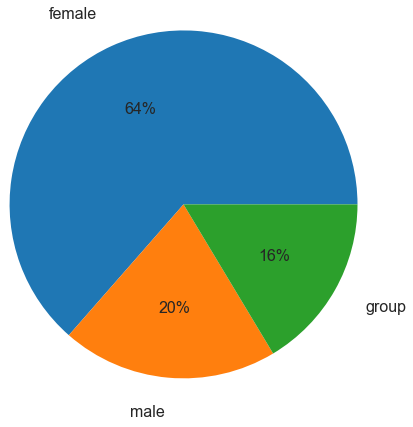

In [11]:
df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male'] else 'group' for elem in df_kiva_loans['borrower_genders'] ]

borrowers = df_kiva_loans['borrower_genders'].value_counts()

plot = borrowers.plot.pie(fontsize=16, autopct='%1.0f%%', labeldistance=1.2, radius=2)

Выясняется, что большинство заёмщиков — женщины, и это весьма неожиданно.

Что это может означать?

Например то, что женщины используют Kiva, чтобы получить финансирование и развивать собственные проекты в странах (большинство из которых являются странами третьего мира), где традиционно женщинам это было сделать крайне тяжело.


**В каких странах преобладают мужчины? Группа людей?**

In [13]:
# Отсортируем страны доля которых в датасете меньше 0,5%

countries = df_kiva_loans['country'].value_counts()[df_kiva_loans['country'].value_counts(normalize=True)> 0.005]
list_countries = list(countries.index)

In [14]:
# зададим для групповых участников займа категорию group:

df_kiva_loans['borrower_genders'] = [elem if elem in ['female','male']\
                                     else 'group' for elem in df_kiva_loans['borrower_genders'] ]


In [15]:
# Сгруппируем датасет по странам и гендерному признаку, 
# переведём их соотношение в процентное, отфильтруем пустые значения
# отсортируем сначала по мужчинам. затем по женщинам:

df_male_by_country = \
    df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=['male', 'female'])[-20:]

df_male_by_country = df_male_by_country[['female', 'male', 'group']]

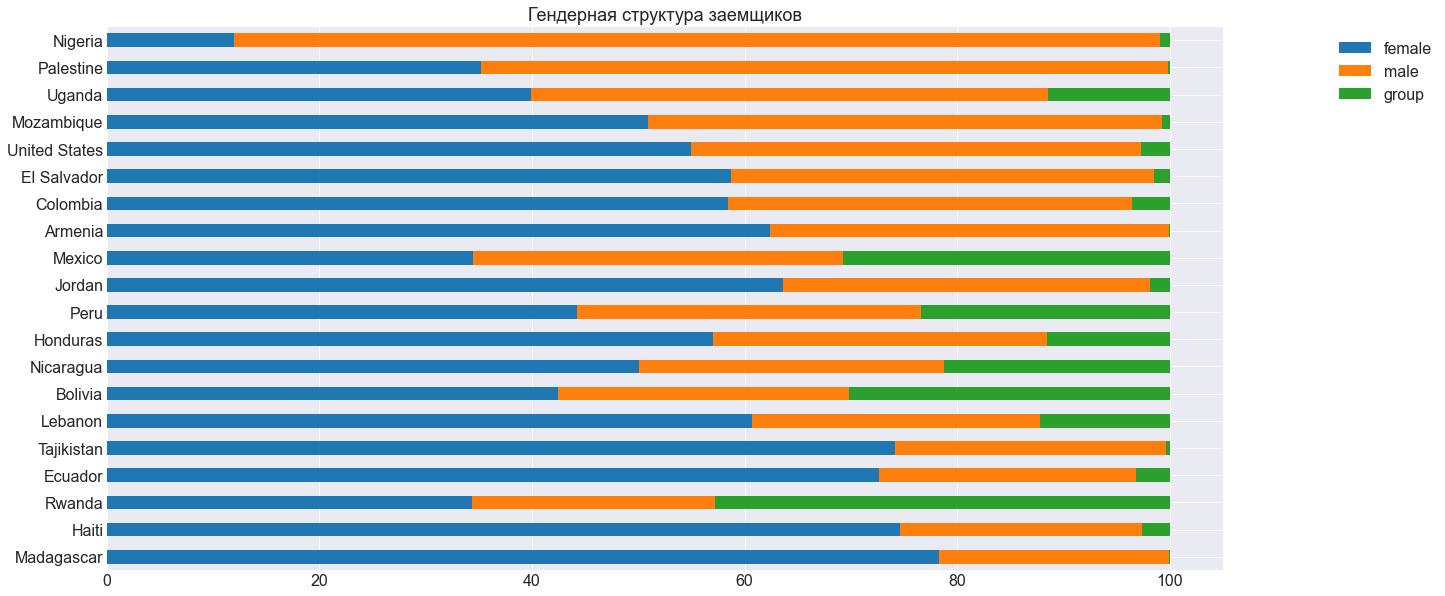

In [16]:
# Отрисуем график соотношения полов по странам, где большее количество мужчин:

plot = df_male_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

In [18]:
# Отсортируем значения по наибольшему соотношению совместных групп мужчин и женщин:

df_group_by_country = df_male_by_country.sort_values(by=['group', 'male'])[-20:]


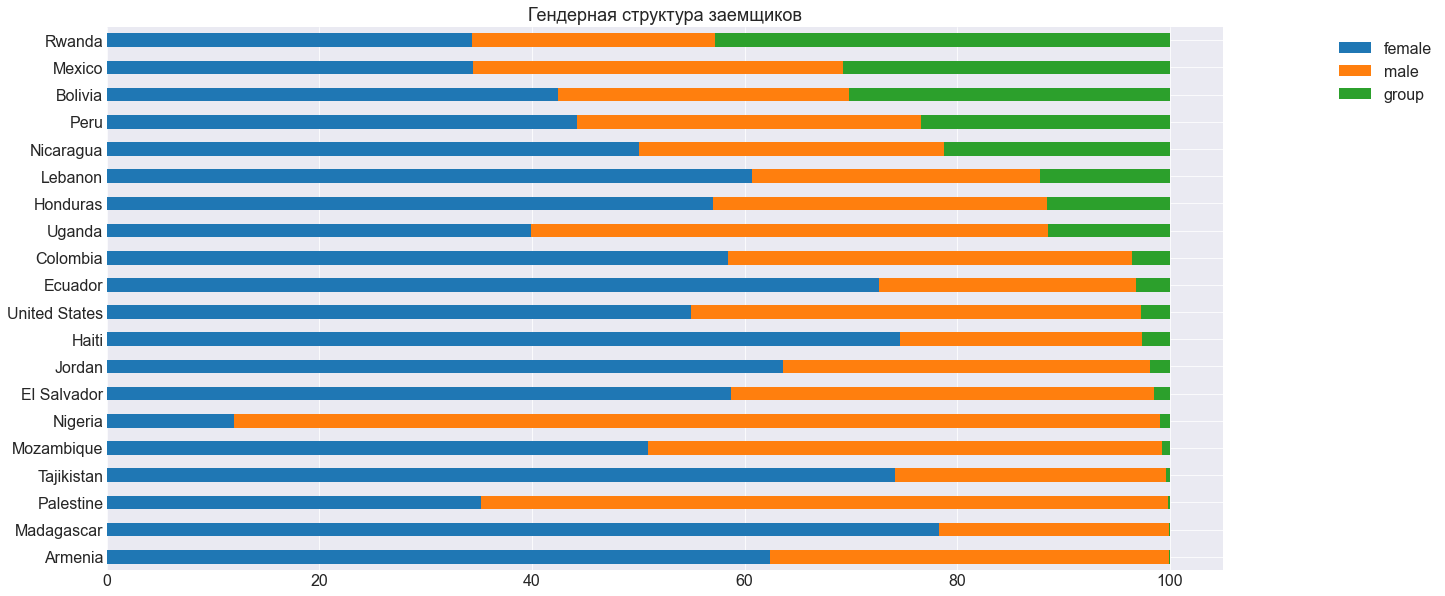

In [19]:
# Отрисуем график соотношения полов по странам, где большее количество групповых заёмщиков:
plot = df_group_by_country.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()


**Изучим несколько займов с очень большими суммами. Что можно сказать о назначении этих заявок? В каких странах они оформлены? Каков гендерный состав заявителей?**

In [20]:
# Наблюдаемое отклонение от среднего
dev = (df_kiva_loans['loan_amount']-df_kiva_loans['loan_amount'].mean()).abs()
# Стандартное отклонение
std = df_kiva_loans['loan_amount'].std()
# Фильтруем исходный набор данных
df_kiva_loans_trimmed = df_kiva_loans[~(dev>3*std)]

# Фильтруем исходный набор данных, находим значения только большие 3х сигм
df_kiva_loans_anomal = df_kiva_loans[dev>3*std]


In [21]:
# Найдём среднее, медианное, модальное значение больших займов
print('среднее значение:   {}'.format(df_kiva_loans_anomal.loan_amount.mean()))
print('медианное значение: {}'.format(df_kiva_loans_anomal.loan_amount.median()))
print('модальное значение: {}'.format(df_kiva_loans_anomal.loan_amount.mode()[0]))

среднее значение:   6282.033285565399
медианное значение: 5425.0
модальное значение: 5000.0


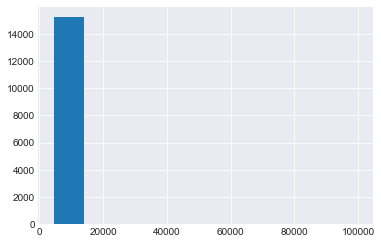

In [22]:
df_kiva_loans_anomal.loan_amount.hist()

In [23]:
df_kiva_loans_anomal['loan_amount'].count()


15352

In [24]:
#  Сумма всех больших займов в миллионах долларов
df_kiva_loans_anomal['loan_amount'].sum() / 1000000

96.441775

In [25]:
# Сумма всех ссуд более 3 сигм в процентном соотношении к общей сумме выданных денежных средств
df_kiva_loans_anomal['loan_amount'].sum() / df_kiva_loans.loan_amount.sum() *100

17.05662672858983

Довольно интересно, что в аномальных значениях все три статистических показателя находятся относительно близко друг к другу. Значит в больших ссудах, больше было займов в районе 5000 долларов, что в принципе видно из графика ниже. Поэтому стоит исследовать займы в районе 5000 долларов, как отдельную категорию, тем более что таких ссуд было довольно много - **15 352 займа**, на сумму **96,4 миллиона долларов**, а это очень много - **17 процентов от всей выданной денежной массы**.

In [26]:
# Изучим страны в которых были выданы такие ссуды:

countries_big_loans = df_kiva_loans_anomal['country'].\
value_counts()[df_kiva_loans_anomal['country'].value_counts(normalize=True)> 0.005]

In [27]:
countries_big_loans

United States                           3830
Paraguay                                2111
Bolivia                                 1624
Rwanda                                  1338
Peru                                    1309
The Democratic Republic of the Congo    1101
Mexico                                   564
Guatemala                                560
Ecuador                                  284
Senegal                                  279
Kenya                                    224
Dominican Republic                       204
Myanmar (Burma)                          167
Vietnam                                  154
Tanzania                                 138
Congo                                    115
Mali                                     112
Burundi                                  110
Samoa                                     93
Honduras                                  83
Name: country, dtype: int64

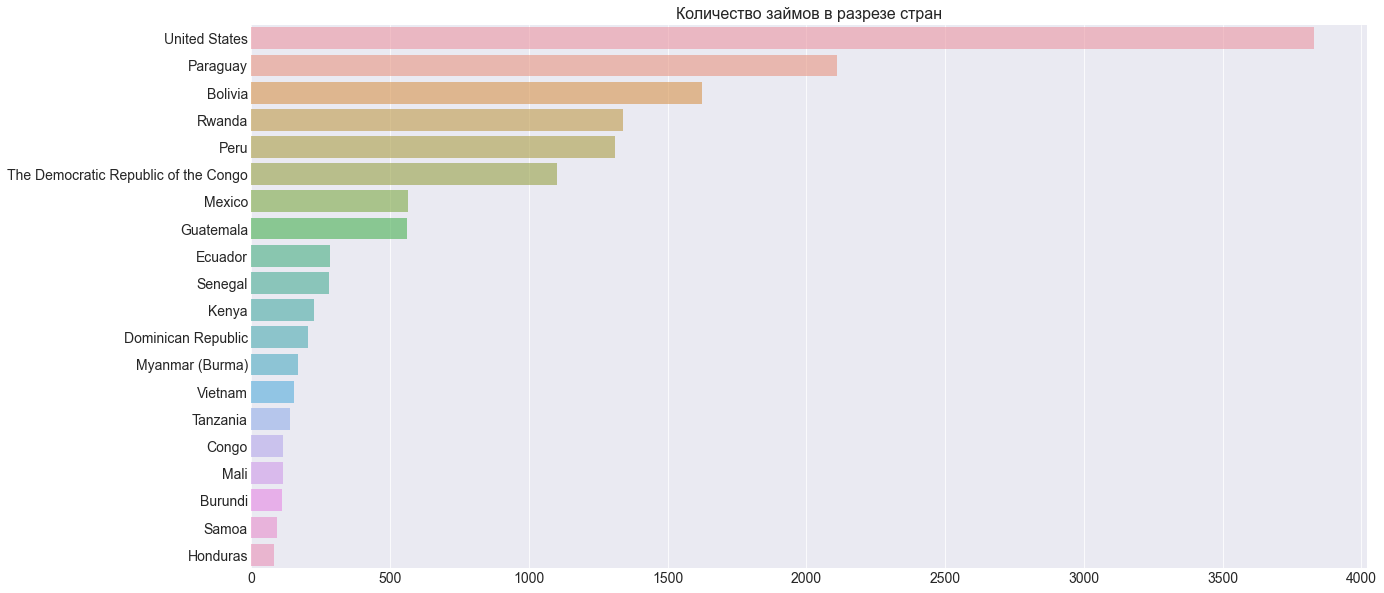

In [28]:
plt.figure(figsize=(20,10))
plt.title("Количество займов в разрезе стран", fontsize=16)
plt.tick_params(labelsize=14)
sns.barplot(y=countries_big_loans.index, x=countries_big_loans.values, alpha=0.6)
plt.show()


Теперь очевидно, что является причиной таких значительных и примерно одинаковых выбросов, это займы в США и двух Южно-Американских стран, а также не самых бедных стран Африки и также займы в других странах Южной Амереики, а также Въетнам. Но  в общей массе привалирует США и страны Южной Америки


In [29]:
(countries_big_loans[0:5] * df_kiva_loans_anomal.loan_amount.median()).sum()

55400100.0

Первая пятёрка стран имеет в сумме займов на 55,4 млн долларов. 

In [30]:
# Изучим данные на назначение больших займов:
sectors = df_kiva_loans['sector'].value_counts()
df_kiva_sector_anomal = \
    df_kiva_loans_anomal[df_kiva_loans_anomal['sector'].isin(sectors[:9].index.values)]\
    .groupby(['sector', 'activity'])['loan_amount']\
    .count()\
    .reset_index()

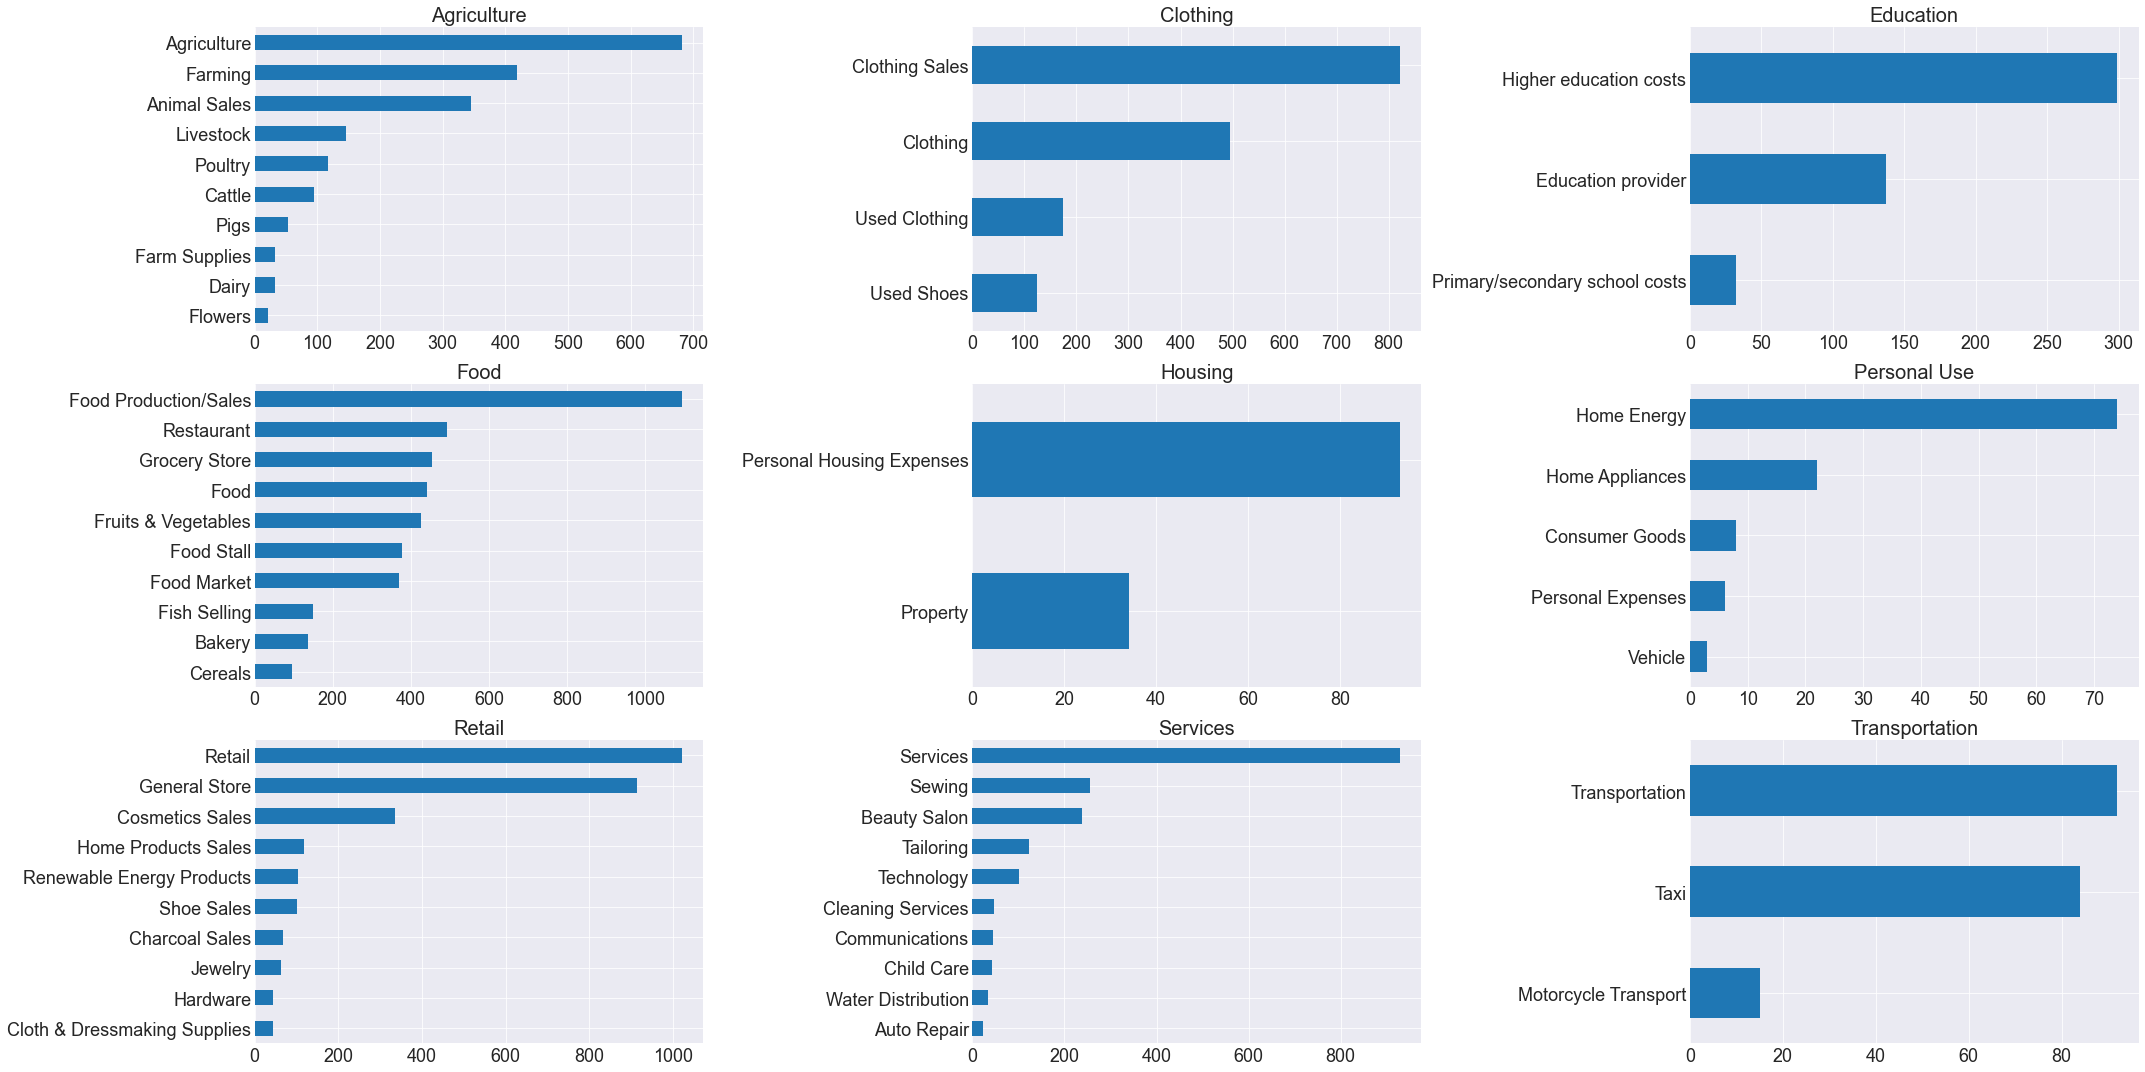

In [31]:
fig,axes = plt.subplots(3,3, sharex=False, squeeze=False, figsize=(30,15))

for ax,q in zip(axes.ravel(), df_kiva_sector_anomal.sector.unique()):
    tmp_df = df_kiva_sector_anomal[df_kiva_sector_anomal.sector.eq(q)]\
                .dropna()\
                .sort_values(by='loan_amount')[-10:]
    ax.set_title(q, fontsize=20)  
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()
    
    tmp_df.plot.barh(x='activity', ax=ax, legend=None, fontsize=18)

Относительно общей картины распределения займов по всем странам, в пропорциональном соотношении к странам с большей долей крупных займов, изменилось количество ссуд по следующим позициям:

* **Агрокультурный сектор:** на фермерство выдано больше займов чем на сельское хозяйство, что может говорить о развитом фермерском хозяйстве в США и Южной Америке(ЮА). Также заметно больше выдано ссуд на разведение свиней, это может быть связано с тем, что США и страны ЮА христианские, в отличии от большинства стран Африки и Азии. Соотношение по позициям молочных культур и крупного рогатого скота в общем датасете было примерно одинаково, однако в датасете больших ссуд ссуды на КРС выросли, тем временем как ссуды на молочные культуры упали, что может говорить о большей заинтересованности "богатых" стран в производстве мяса ,чем молока. По остальным позициям в данном секторе пропорции значительно не изменились.
* **Одежда:** в "богатых" странах больше выделено денежных средств на покупку одежды и покупку бывшей в употреблении обуви. Возможно в ЮА странах культура внешнего вида больше развита, чем в странах Африки и Азии, где больше озабочены пропитанием и жизненно важными предметами быта, чем одеждой и обувью.
* **Образование:** в пропорциональном соотношении в "бедных" странах, люди больше озабочены получением начального образования чем в "богатых". Также видно, что в датасете больших займов отсутствуют займы на покупку компьютеров, это может говорить как об относительной дешевизне этих товаров в "богатых" странах ,так и о развитых кредитных системах в магазинах компьютерной техники, где нет необходимости брать сторонние займы.
* **Еда:** Заметно большее количество выданных займов на ресторанное дело в богатых странах, также отсутствуют займы на рыбную ловлю, что может говорить о рационном дисбалансе в сторону рыбных продуктов в "бедных" странах.
* **Жильё:** Заметный пропорциональный дисбаланс затрат на жилую недвижимость, в бедных странх больше ссуд на личные расходы по жилью.
* **Розничная торговля:** в "богатых" странах значительно больше выдано ссуд на розничную торговлю, чем в "бедных". Заметно меньше ссуд на торговлю древесным углём.
* **Сервисы:** в "богатых" странах совершенно отсутствуют ссуды на интернет кафе, в отличии от "бедных", что говорит о развитой сети интернет в "богатых" странах. В "бедных" странах больше ссуд выдают на портное дело, что коррелируется с большей выдачей ссуд на продажу одежды в "богатых" странах - в "богатых" странах больше покупают готовую одежду ,чем заказывают у портного. Это может говорить о финансовой недоступности мировых сетей одежды для бедных стран, ввиду низкой оплаты труда в бедных странах, дешевле заказать у портного.
* **Транспорт:** при сравнении двух графиков общего датасета и датасета крупных ссуд сразу видно присутствие Азиатских стран в датасете общем, так как бОльшая часть ссуд выдаётся на мотоциклы и рикши, а как известно в Азии рикши и мотоциклы более популярны чем Такси.

In [32]:
# Изучим гендерный состав заявителей:

df_gender_by_anomal = \
    df_kiva_loans_anomal[df_kiva_loans_anomal['country'].isin(countries_big_loans.index.values)]\
    .groupby(['country', 'borrower_genders'])['borrower_genders']\
    .count()\
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())\
    .unstack('borrower_genders')\
    .fillna(0)\
    .sort_values(by=[ 'group', 'female'])

df_gender_by_anomal = df_gender_by_anomal[['female', 'male', 'group']]

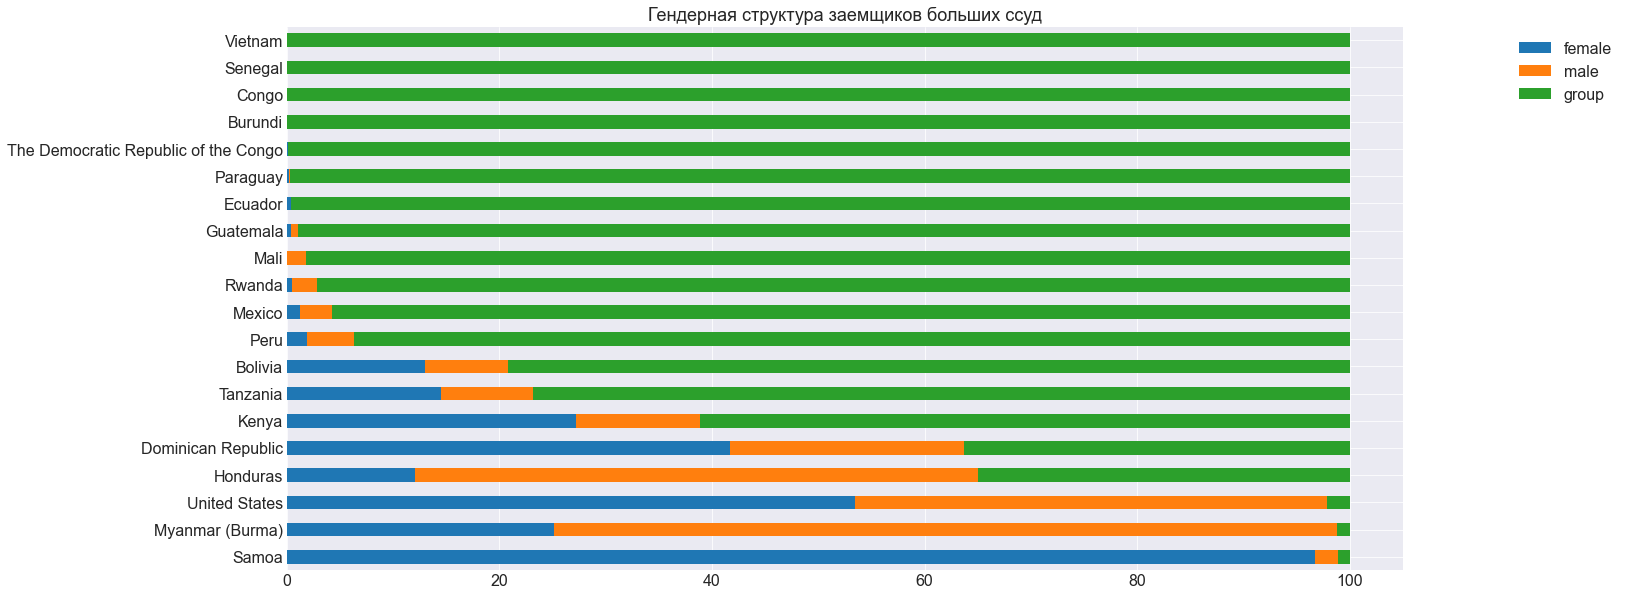

In [33]:
plot = df_gender_by_anomal.plot.barh(
        figsize=(20,10)
        , fontsize=16
        , stacked=True
        , title='Гендерная структура заемщиков больших ссуд')
plot.title.set_size(18)
plot.legend(loc=1, bbox_to_anchor=(1.2, 1), fontsize=16)
plot.set(ylabel=None, xlabel=None)
plt.show()

Как видим, больший процент заёмщиков больших ссуд это группы людей.


**Попробуем найти связь между странами (макрорегионами), полом заёмщика и суммой заявки. Какие выводы можно сделать из этих данных?**

In [34]:
# Создадим датасет  с зависимостью суммы  заявки от пола по макро регионам. Зависимость для наглядности выразим в процентах:


df_amount_gender_amount = df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
                          .groupby(['world_region', 'borrower_genders'])['loan_amount']\
                          .count()\
                          .groupby(level=0).apply(lambda x: x / x.sum() * 100)\
                          .unstack('borrower_genders')\
                          .fillna(0)\
                          .sort_values(['female'], ascending=False)
df_amount_gender_amount

borrower_genders,female,group,male
world_region,,,
South Asia,85.648659,11.408621,2.942721
East Asia and the Pacific,80.841824,13.421939,5.736236
Europe and Central Asia,74.017949,0.217743,25.764308
Arab States,63.618910,1.823854,34.557235
Sub-Saharan Africa,54.693210,18.893776,26.413013
Latin America and Caribbean,53.923291,12.563428,33.513281


[Text(0, 0.5, '')]

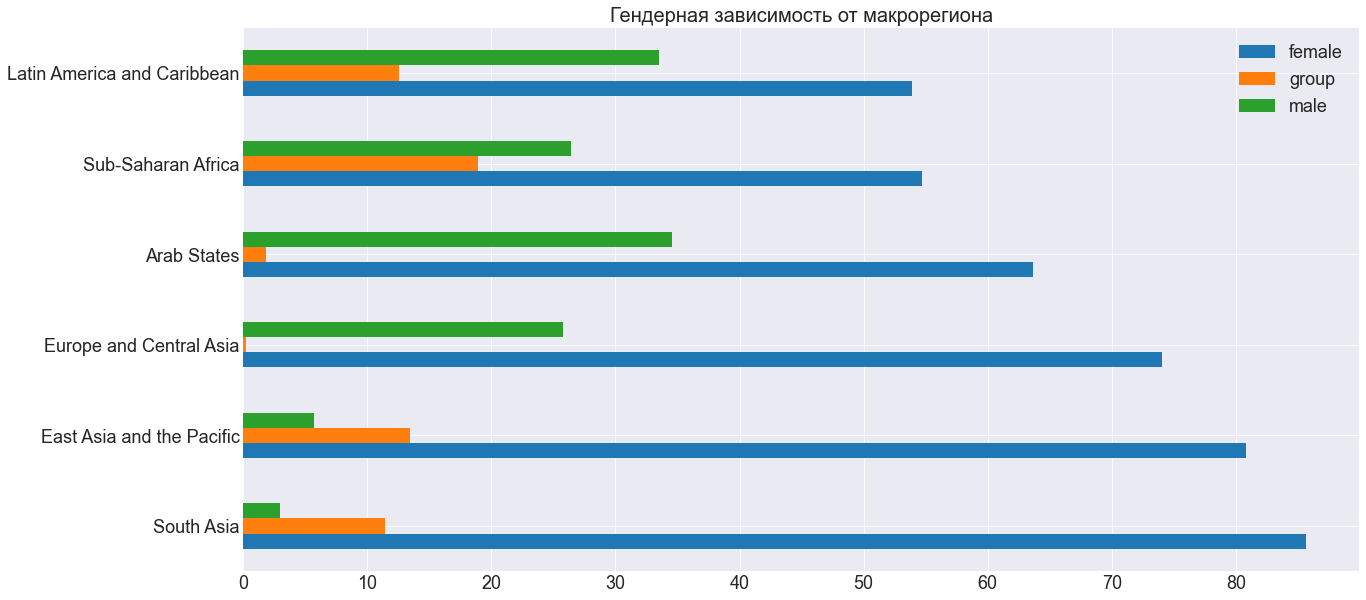

In [35]:
plot = df_amount_gender_amount.plot.barh(figsize=(20,10),
                                         fontsize=18,
                                         title='Гендерная зависимость от макрорегиона',
                                         stacked=False)
plot.title.set(fontsize=20)
plot.legend(loc=1, fontsize = 18)
plot.set(ylabel=None)


В большинстве случаев заём берут женщины

#### Теперь найдём ответы на следующие вопросы:
- Зависимость пола заёмщика от региона планеты, сектора экономики.
- Влияние такого атрибута займа, как **Количество кредиторов** (lender_count), на суммы и сроки займов.
- Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.
- Зависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж», в разрезе **макрорегионов**.

* Зависимость пола заёмщика от региона планеты, сектора экономики.

In [36]:
# Создадим датасет  с зависимостью суммы  заявки от пола по макро регионам. Зависимость для наглядности выразим в процентах:
df_region_sector_gender = df_kiva_loans[df_kiva_loans['country'].isin(countries.index.values)]\
                          .groupby(['world_region', 'sector'])['borrower_genders']\
                          .value_counts()\
                          .groupby(level=(0,1)).apply(lambda x: x / x.sum() * 100)\
                          .unstack(['borrower_genders'])\
                          .fillna(0)
df_region_sector_gender

borrower_genders                      female      group       male
world_region       sector                                         
Arab States        Agriculture     80.346821   4.624277  15.028902
                   Arts            82.795699   1.075269  16.129032
                   Clothing        93.939394   2.424242   3.636364
                   Construction    31.818182   0.000000  68.181818
                   Education       51.358025   0.938272  47.703704
...                                      ...        ...        ...
Sub-Saharan Africa Personal Use    37.618214   3.555166  58.826620
                   Retail          64.402829  14.191458  21.405713
                   Services        67.970781   8.171351  23.857868
                   Transportation  14.703493   3.371243  81.925264
                   Wholesale       37.500000  21.093750  41.406250

[89 rows x 3 columns]

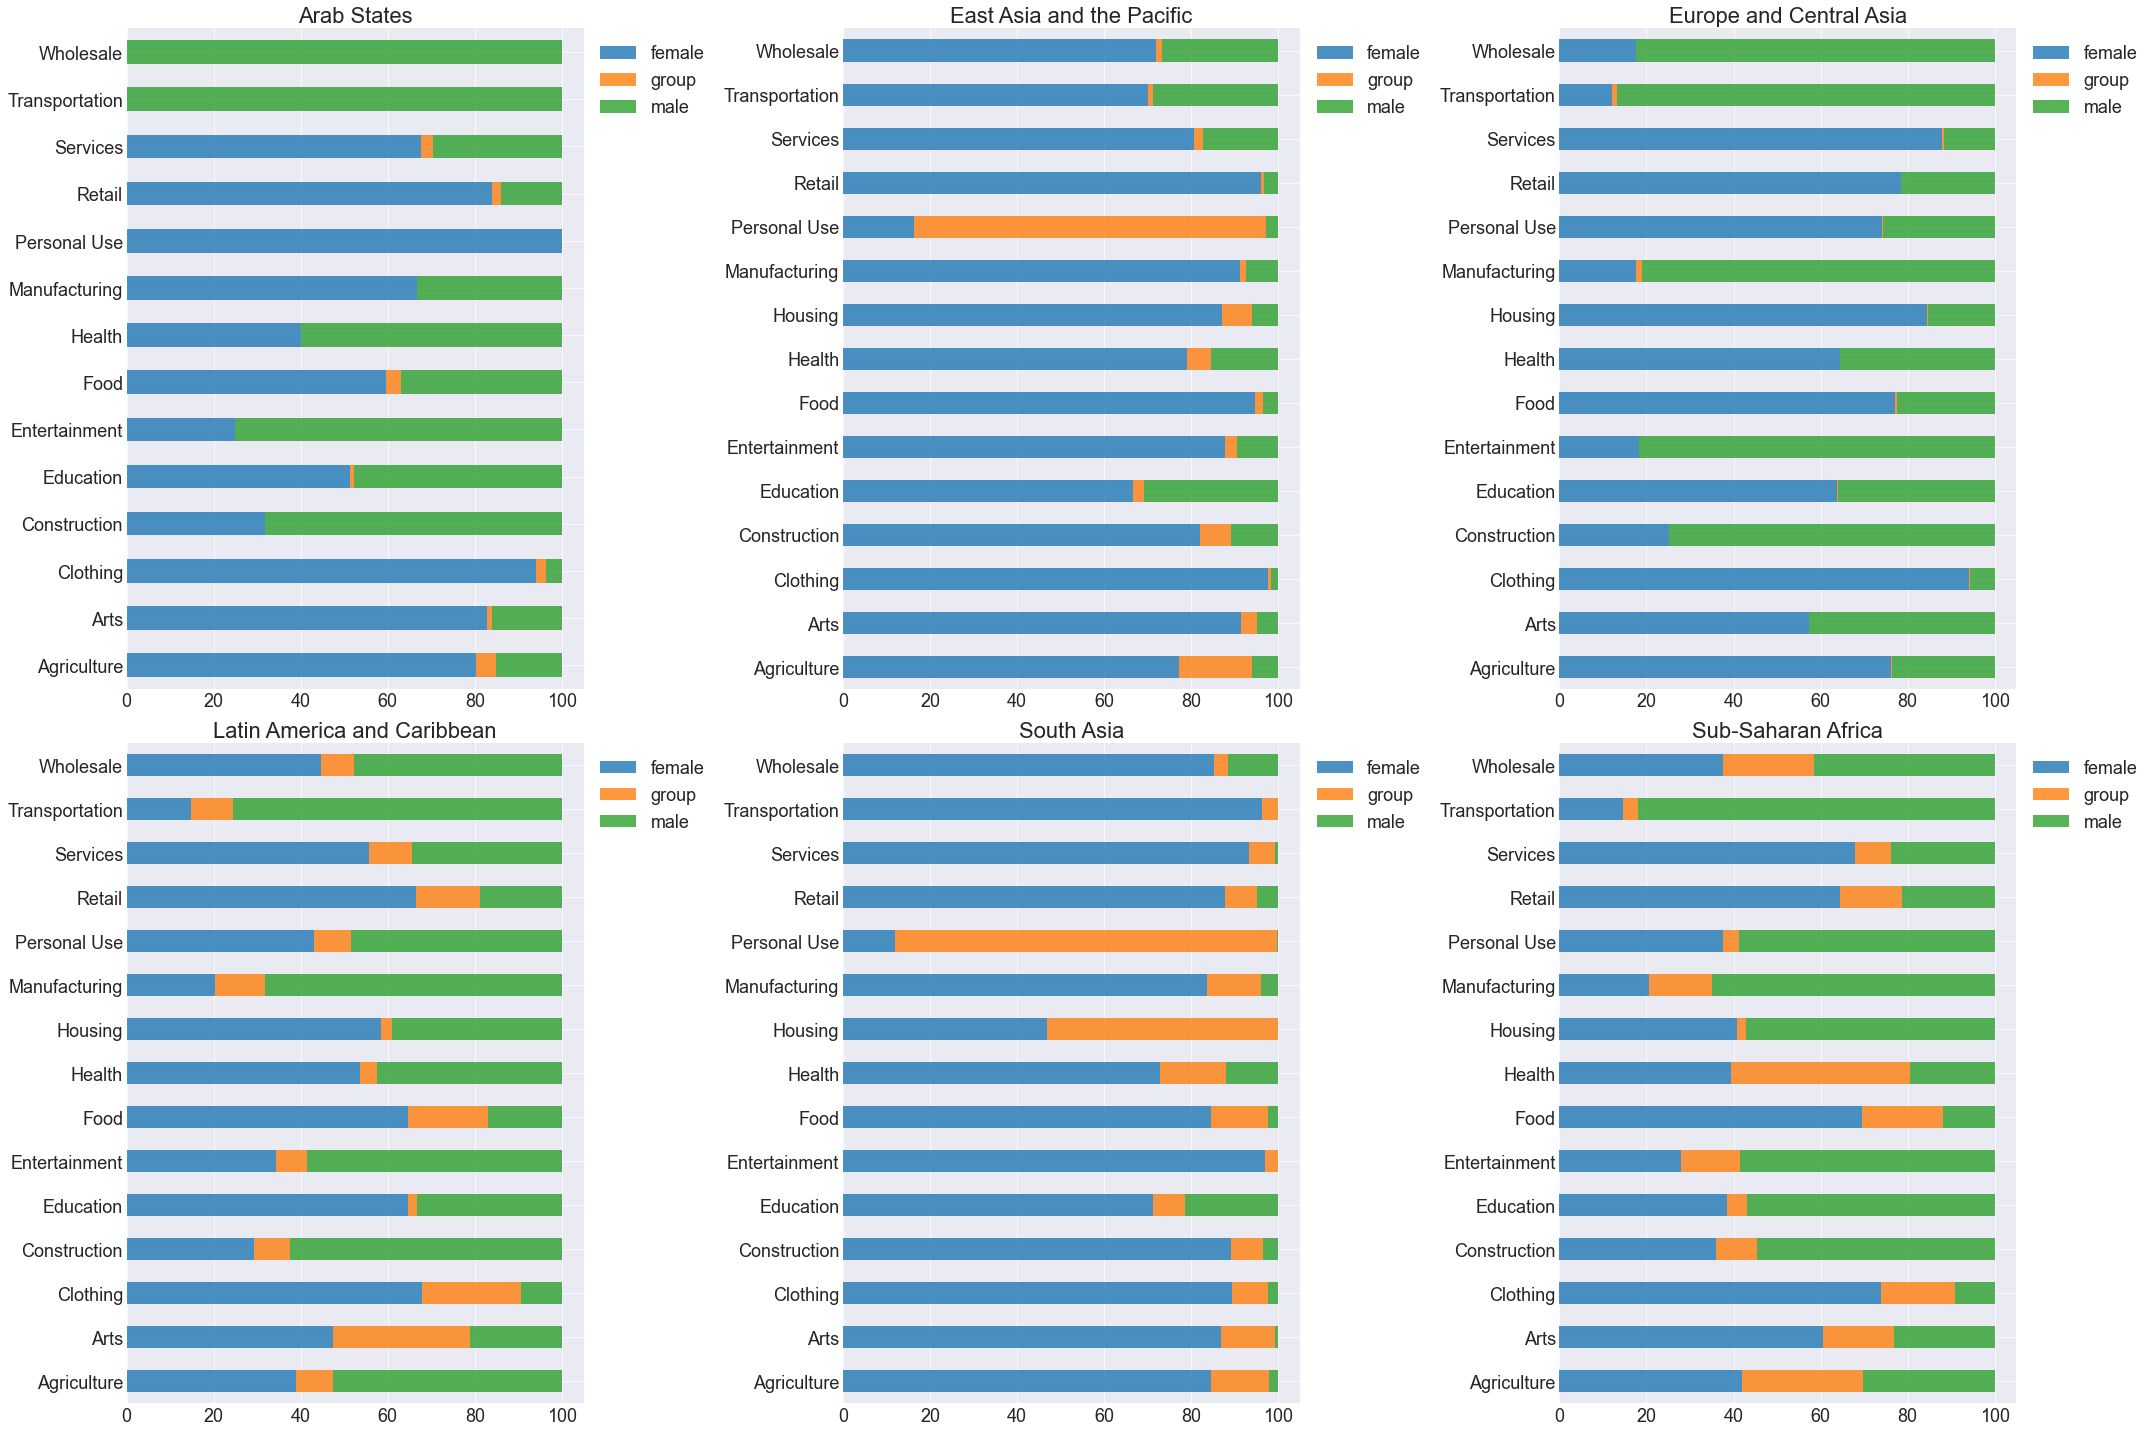

In [37]:
fig,axes = plt.subplots(2,3, sharex=False, squeeze=False, figsize=(30,20))


for ax,q in zip(axes.ravel(), df_region_sector_gender.index.levels[0]):
    tmp_df = df_region_sector_gender.xs(q).dropna()
    ax.yaxis.label.set_visible(False)
    plt.tight_layout()   
    tmp_df.plot.barh(ax=ax,
      fontsize=18
    , stacked=True
    , title= q
    , alpha=0.8)
    ax.title.set_size(22)    
    ax.set(ylabel=None, xlabel=None)
    ax.legend(loc=1, bbox_to_anchor=(1.3, 1), fontsize=18)
plt.show()

In [38]:
# drop na (missing) values
df_loans_dates = df_kiva_loans_trimmed.dropna(subset=['disbursed_time', 'funded_time'], how='any', inplace=False)

# dates columns:
dates = ['posted_time','disbursed_time']

# format dates:
df_loans_dates[dates] = df_loans_dates[dates].applymap(lambda x : x.split('+')[0])
df_loans_dates[dates] = df_loans_dates[dates].apply(pd.to_datetime)

# calculate time interval
df_loans_dates.loc[:, 'time_delta'] = df_loans_dates['disbursed_time']-df_loans_dates['posted_time']
df_loans_dates.loc[:, 'time_delta'] = df_loans_dates['time_delta'] / timedelta(days=1) 

# remove outliers +-3 sigma
dev = (df_loans_dates['time_delta']-df_loans_dates['time_delta'].mean()).abs()
std = df_loans_dates['time_delta'].std()
# Keep rows where time_funding interval > 0 only
df_loans_dates_delta = df_loans_dates[~(dev>3*std) & (df_loans_dates.loc[:, 'time_delta']>0)]

* Влияние такого атрибута займа, как **Количество кредиторов** (lender_count) на суммы и сроки займов.

создадим датасет в котором будут три поля - 'lender_count', 'loan_amount', 'time_delta', на основании этих данных выстроим тепловую карту, где значениями будут сроки займов:

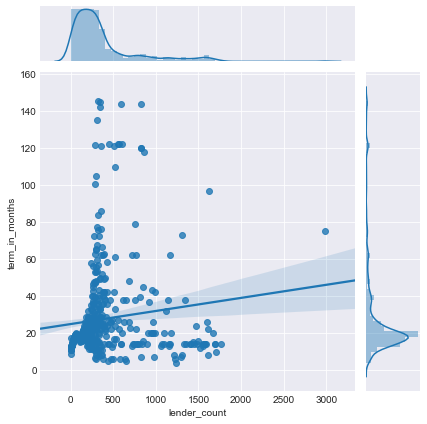

In [39]:
df_lender_amount_term = df_kiva_loans[[ 'lender_count', 'loan_amount', 'term_in_months']].dropna()

df_lender_amount_term = df_lender_amount_term.round(0).dropna()

df_lad = df_lender_amount_term.groupby(['lender_count'])\
                               ['term_in_months','loan_amount']\
                               .mean()\
                               .dropna()\
                               .reset_index()

# Посмотрим кореллирует ли параметр количеств кредиторов с продолжительностью займа:

sns.jointplot(x='lender_count', y='term_in_months', data=df_lad, kind='reg')
ax.set_title("Кореляция между количеством кредиторов и сроком займа ", fontsize=20)
ax.set_ylabel(None)
ax.set_xlabel('Количество кредиторов', fontsize=18)
ax.tick_params(labelsize=16)

# plt.tight_layout()
# plt.show()

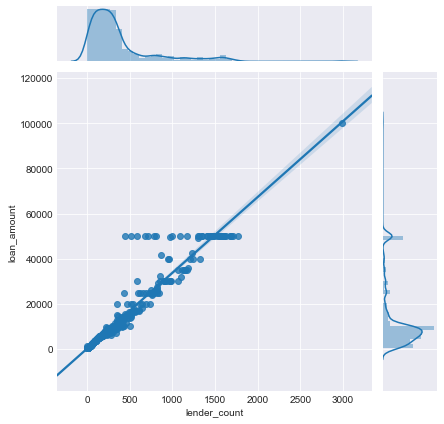

In [40]:
# Посмотрим кореллирует ли параметр количеств кредиторов с продолжительностью займа:

sns.jointplot(x='lender_count', y='loan_amount', data=df_lad, kind='reg')
ax.set_title("Кореляция между количеством кредиторов и суммой займа ", fontsize=20)
ax.set_ylabel(None)
ax.set_xlabel('Количество кредиторов', fontsize=18)
ax.tick_params(labelsize=16)

Как видно, чем больше сумма займа ,тем дольше срок займа и большее количество кредиторов. Прямая корреляция сильно выражена для параметров - количество кредиторов и сумма займа.

* Влияние показателя **MPI** (многомерный индекс бедности) в разных странах на суммы займов и сроки погашения.

In [41]:
# Создадим датасет  с показателями MPI, country, loan_amount, term_in_months, 
# а также отфильтруем страны у которых индекс MPI не определён или равен нулю:

df_mpi_amount_term = df_kiva_loans[['MPI', 'loan_amount', 'term_in_months']]\
                                  .dropna()\
                                  .loc[df_kiva_loans['MPI'] !=0]\
                                  .sort_values('MPI')

In [42]:
df_mat = df_mpi_amount_term.groupby('MPI')['loan_amount', 'term_in_months']\
                                 .mean()\
                                 .sort_values('MPI')\
                                 .reset_index()

In [43]:
df_mat.head(5)

,MPI,loan_amount,term_in_months
0,0.006333,1121.226302,18.895608
1,0.013680,673.139109,14.001830
2,0.018250,1109.405739,12.000888
3,0.018333,2839.738806,13.679104
4,0.020143,912.200000,51.016000


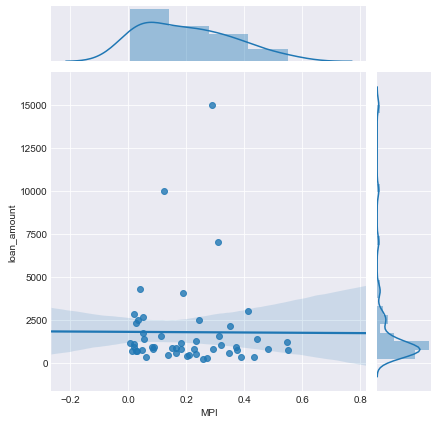

In [44]:
# Посмотрим кореллирует ли показатель бедности страны на сумму займа:

sns.jointplot(x='MPI', y='loan_amount', data=df_mat, kind='reg')
ax.set_title("Кореляция между MPI и суммой займа ", fontsize=20)
ax.set_ylabel(None)
ax.set_xlabel('показатель бедности', fontsize=18)
ax.tick_params(labelsize=16)

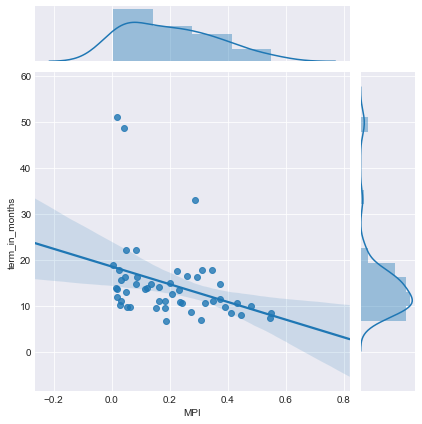

In [45]:
# Посмотрим кореллирует ли показатель бедности страны на срок займа:

sns.jointplot(x='MPI', y='term_in_months', data=df_mat, kind='reg')
ax.set_title("Кореляция между MPI и суммой займа ", fontsize=20)
ax.set_ylabel(None)
ax.set_xlabel('показатель бедности', fontsize=18)
ax.tick_params(labelsize=16)

Явной кореляции между индексом бедности страны и суммой займа не обнаружено, но зато есть обратная кореляция между индексом бедности и длительностью возврата займа, чем богаче страна, тем на меньший срок выдаётся займ

* Взаимозависимости таких метрик, как «Сумма займа», «Срок займа», «Время финансирования заявки», «Ежемесячный платёж» в разрезе **макрорегионов**.

In [46]:
# Создадим датасет с интересующими нас колонками, 
# а также добавим столбец с ежемесячным платежём:

df_loan_term_app = df_loans_dates_delta[['world_region',
                                         'loan_amount', 
                                         'term_in_months', 
                                         'time_delta']]\
                                         .dropna()\
                                         .round(2)

df_loan_term_app['monthly_payment'] = (df_loans_dates_delta['loan_amount']
                                    / df_loans_dates_delta['term_in_months'])\
                                    .round(2)

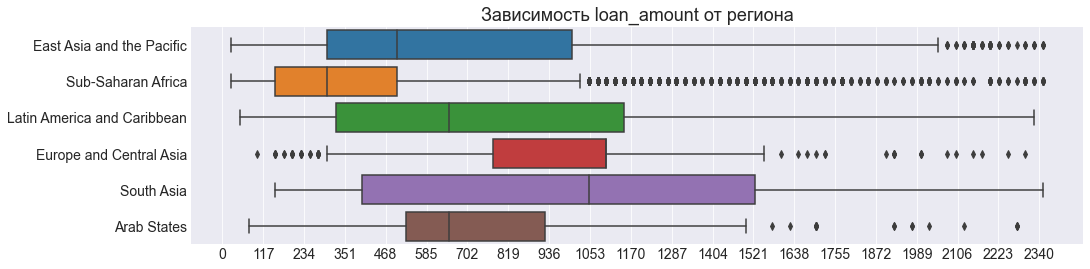

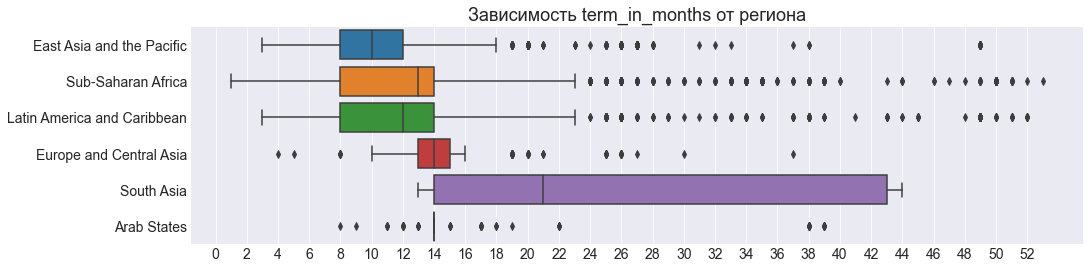

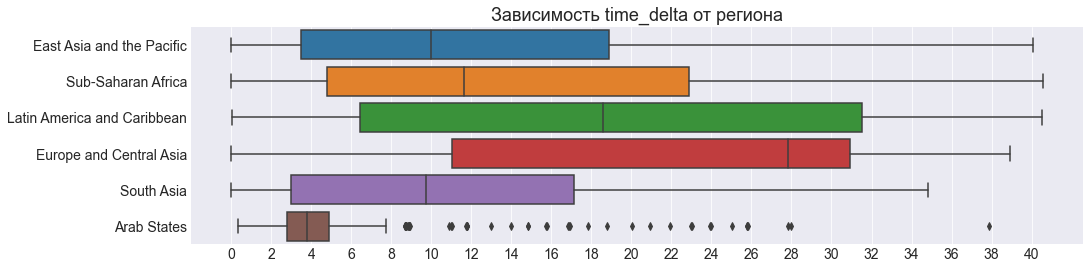

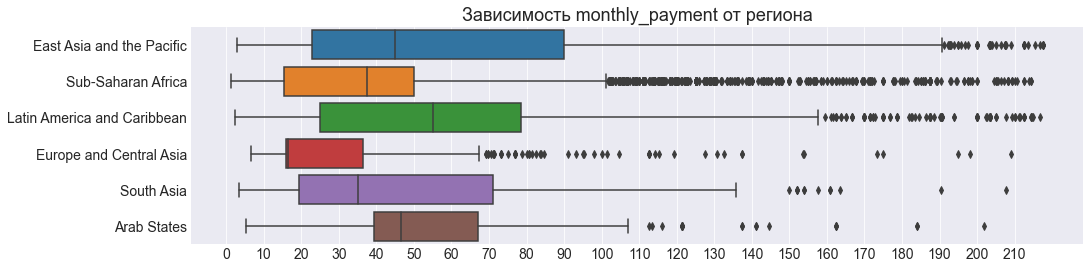

In [47]:
# Отрисуем графики зависимостей наших велечин от макрорегионов:
regions = df_kiva_loans['world_region'].value_counts()
regions_list = regions.index.to_list()

for column in df_loan_term_app.columns[1:]:

    dev = (df_loan_term_app[column] - df_loan_term_app[column].mean()).abs()
    std = df_loan_term_app[column].std()
    df_temp = df_loan_term_app[~(dev>3*std)]

    plt.figure(figsize=(16,4))
    plt.title("Зависимость {} от региона".format(column), fontsize=18)
    plt.xticks(np.arange(0, max(df_temp[column]+1), (max(df_temp[column]//20))))
    plt.tick_params(labelsize=14)

    sns.boxplot(x=column, y='world_region', order=regions_list, data=df_temp)\
    .set(ylabel=None, xlabel=None)
# plt.legend(loc=1, bbox_to_anchor=(1.15, 1), fontsize=16)
plt.show()

* **Изучим зависимость суммы займа от региона (loan amount):**
В среднем. самые большие займы выдают в Южной Азии, меньше всего суммы займов к югу от Сахары. В Европе и Центральной Азии хоть и самые крупные займы меньше чем в других регионах, но небольшие займы больше чем в других. Самый большой разброс по суммам займа в Латинской Америке, на Карибах и Южной Азии.
* **Изучим зависимость срока займа от региона (term in months):**
По арабским странам судить сложно из-за слишком незначительной выборки. Самые длительные займы в Южной Азии с положительным скосом от среднего в сторону длительных займов.В Европе и Центральной Азии сроки займа находятся в узком коридоре значений, то но тоже длительные, тем временем как в Восточной Азии и Океании сроки займов гораздо меньше по сравнению с Европой и Южной Азией.
* **Изучим зависимость срока от подачи заявки до выдачи денег от региона - дельта (time_delta):**
Хоть сроки займа в Европе  и Центральной Азии выше чем в других регионах, но также и дельта выше чем в других регионах. В Латинской Америке и на Карибах очень большой разброс дельты, рассматривают как и быстро, так и долго. В Арабских странах самая быстрая дельта. В Южной Азии дельта от трёх дней до 17 с медианным значением 10 дней.
* **Изучим зависимость ежемесячного платежа  от региона - дельта (time_delta):**
Самый высокий платёж в Латинской Америке и  Карибах, это корелируется с относительно небольшими сроками займов и довольно высокой суммой зайсов. Самые низкие ежемесячные платежи в Европе и Центральной Азии, что также связано с довольно большими сроками займа. Та же картина наблюдается и у Южной Азии, так как в этом регионе самые длительные сроки займа.
    